# Hierarchical Waste Classifier - Vision Transformer

This notebook trains a **Hierarchical Vision Transformer** for waste classification:
- **30 fine-grained classes** (specific waste types)  
- **7 super categories** (Metal, Paper, Glass, Plastic, Styrofoam, Organic, Textiles)

## Quick Start
**Just run all cells in sequence** - the notebook is designed to work smoothly from top to bottom.

### Key Features:
- **Streamlined execution** - no complex setup needed
- **Live training progress** with tqdm bars
- **Dual-head architecture** for hierarchical classification
- **Automatic model saving**

### Requirements:
Update the `dataset_path` in cell 3 to point to your dataset location.

## [PACKAGE] Import Libraries
Import all necessary libraries for the hierarchical waste classification project.

In [27]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.transforms import v2

In [ ]:
import os

dataset_path = '/kaggle/input/household-waste-30-classes/images/images'
#dataset_path = '/teamspace/studios/this_studio/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1/images/images'

# Check if dataset path exists
if not os.path.exists(dataset_path):
    print(f"[X] Dataset path not found: {dataset_path}")
    print("Please update the dataset_path variable with the correct path to your dataset")
    # You may need to update this path based on your environment
else:
    print(f"[CHECK] Dataset path found: {dataset_path}")

full_dataset = ImageFolder(dataset_path)

## [FOLDER] Dataset Loading
Load the household waste dataset using ImageFolder. Update the `dataset_path` variable to point to your dataset location.

In [29]:
class_map_dict = full_dataset.class_to_idx

def get_class(num_label):
    for class_name, class_index in class_map_dict.items():
        if class_index == num_label:
            return class_name
    return None

class_names = list(class_map_dict.keys())
print(f'number of classes: {len(class_names)}')
print('class_names:', class_names)

number of classes: 30
class_names: ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']


## [TAG] Class Mapping Utilities
Define helper functions for class name mapping and display the dataset classes.

In [30]:
# [CONSTRUCTION] Hierarchical Classification System - 7 Super Classes (Refactored)
import numpy as np
import pandas as pd

# Define super-classes for hierarchical classification (7 categories)
SUPER_CLASSES = {
    0: [  # Metal_Aluminum
        'aerosol_cans',
        'aluminum_food_cans',
        'aluminum_soda_cans',
        'steel_food_cans'
    ],
    1: [  # Cardboard_Paper
        'cardboard_boxes',
        'cardboard_packaging',
        'magazines',
        'newspaper',
        'office_paper',
        'paper_cups'
    ],
    2: [  # Glass_Containers
        'glass_beverage_bottles',
        'glass_cosmetic_containers',
        'glass_food_jars'
    ],
    3: [  # Plastic_Items
        'disposable_plastic_cutlery',
        'plastic_cup_lids',
        'plastic_detergent_bottles',
        'plastic_food_containers',
        'plastic_shopping_bags',
        'plastic_soda_bottles',
        'plastic_straws',
        'plastic_trash_bags',
        'plastic_water_bottles'
    ],
    4: [  # Styrofoam_Products
        'styrofoam_cups',
        'styrofoam_food_containers'
    ],
    5: [  # Organic_Waste
        'coffee_grounds',
        'eggshells',
        'food_waste',
        'tea_bags'
    ],
    6: [  # Textiles_Clothing
        'clothing',
        'shoes'
    ]
}

SUPER_CLASS_NAMES = {
    0: 'Metal_Aluminum',
    1: 'Cardboard_Paper', 
    2: 'Glass_Containers',
    3: 'Plastic_Items',
    4: 'Styrofoam_Products',
    5: 'Organic_Waste',
    6: 'Textiles_Clothing'
}

# Build reverse lookup from class → super_class
CLASS_TO_SUPER = {}
for super_id, class_list in SUPER_CLASSES.items():
    for class_name in class_list:
        CLASS_TO_SUPER[class_name] = super_id

# Create mapping from class index to super class index
CLASS_IDX_TO_SUPER_IDX = {}
SUPER_IDX_TO_CLASS_INDICES = {i: [] for i in range(7)}  # Updated to 7 categories

for class_name, class_idx in class_map_dict.items():
    if class_name in CLASS_TO_SUPER:
        super_idx = CLASS_TO_SUPER[class_name]
        CLASS_IDX_TO_SUPER_IDX[class_idx] = super_idx
        SUPER_IDX_TO_CLASS_INDICES[super_idx].append(class_idx)

def get_super_class_name(class_idx):
    """Get super class name from fine class index"""
    super_idx = CLASS_IDX_TO_SUPER_IDX.get(class_idx, -1)
    return SUPER_CLASS_NAMES.get(super_idx, 'Unknown')

def get_super_class_idx(class_idx):
    """Get super class index from fine class index"""
    return CLASS_IDX_TO_SUPER_IDX.get(class_idx, -1)

def convert_labels_to_super(fine_labels):
    """Convert fine-grained labels to super-class labels"""
    if isinstance(fine_labels, torch.Tensor):
        fine_labels = fine_labels.cpu().numpy()
    
    super_labels = []
    for label in fine_labels:
        super_labels.append(CLASS_IDX_TO_SUPER_IDX.get(int(label), -1))
    
    return torch.tensor(super_labels) if torch.is_tensor(torch.tensor(fine_labels)) else np.array(super_labels)

# Display hierarchical structure
print("[CONSTRUCTION] HIERARCHICAL CLASSIFICATION STRUCTURE (7 SUPER CLASSES)")
print("="*70)
for super_idx, super_name in SUPER_CLASS_NAMES.items():
    class_list = SUPER_CLASSES[super_idx]
    # Create a more readable display name
    display_name = super_name.replace('_', ' & ')
    print(f"\n🗂️  {display_name} ({super_idx}) - {len(class_list)} classes:")
    for i, class_name in enumerate(class_list, 1):
        class_idx = class_map_dict.get(class_name, -1)
        # Clean up class name for display
        display_class = class_name.replace('_', ' ').title()
        print(f"   {i:2d}. {display_class:<35} (idx: {class_idx:2d})")

print(f"\n[CHART] SUMMARY:")
print(f"   • Total fine-grained classes: {len(class_names)}")
print(f"   • Total super classes: {len(SUPER_CLASS_NAMES)} (updated from 6 to 7)")
print(f"   • Average classes per super category: {len(class_names)/len(SUPER_CLASS_NAMES):.1f}")

# Display category distribution
category_sizes = [len(SUPER_CLASSES[i]) for i in range(7)]
print(f"\n📈 CATEGORY DISTRIBUTION:")
for i, (super_idx, super_name) in enumerate(SUPER_CLASS_NAMES.items()):
    size = category_sizes[i]
    percentage = (size / len(class_names)) * 100
    bar = '█' * int(percentage / 3)  # Visual bar
    print(f"   {super_name:<18}: {size:2d} classes ({percentage:5.1f}%) {bar}")

# Verify all classes are mapped
unmapped_classes = [c for c in class_names if c not in CLASS_TO_SUPER]
if unmapped_classes:
    print(f"\n⚠️  UNMAPPED CLASSES ({len(unmapped_classes)}):")
    for cls in unmapped_classes:
        print(f"   • {cls}")
    print("   These classes need to be assigned to a super category!")
else:
    print(f"\n[CHECK] ALL CLASSES SUCCESSFULLY MAPPED!")
    print("   Every fine-grained class belongs to exactly one super category.")

# Show material type distribution for recycling insights
print(f"\n♻️  RECYCLING CATEGORY INSIGHTS:")
recyclable_categories = ['Metal_Aluminum', 'Cardboard_Paper', 'Glass_Containers', 'Plastic_Items']
non_recyclable = ['Styrofoam_Products', 'Organic_Waste', 'Textiles_Clothing']

recyclable_count = sum(len(SUPER_CLASSES[i]) for i in range(4))  # First 4 categories
non_recyclable_count = sum(len(SUPER_CLASSES[i]) for i in range(4, 7))  # Last 3 categories

print(f"   🟢 Typically Recyclable: {recyclable_count} classes ({recyclable_count/len(class_names)*100:.1f}%)")
for i in range(4):
    super_name = SUPER_CLASS_NAMES[i].replace('_', ' & ')
    print(f"      • {super_name}: {len(SUPER_CLASSES[i])} classes")

print(f"   🟡 Special Handling/Non-Recyclable: {non_recyclable_count} classes ({non_recyclable_count/len(class_names)*100:.1f}%)")
for i in range(4, 7):
    super_name = SUPER_CLASS_NAMES[i].replace('_', ' & ')
    print(f"      • {super_name}: {len(SUPER_CLASSES[i])} classes")

[CONSTRUCTION] HIERARCHICAL CLASSIFICATION STRUCTURE (7 SUPER CLASSES)

🗂️  Metal & Aluminum (0) - 4 classes:
    1. Aerosol Cans                        (idx:  0)
    2. Aluminum Food Cans                  (idx:  1)
    3. Aluminum Soda Cans                  (idx:  2)
    4. Steel Food Cans                     (idx: 26)

🗂️  Cardboard & Paper (1) - 6 classes:
    1. Cardboard Boxes                     (idx:  3)
    2. Cardboard Packaging                 (idx:  4)
    3. Magazines                           (idx: 13)
    4. Newspaper                           (idx: 14)
    5. Office Paper                        (idx: 15)
    6. Paper Cups                          (idx: 16)

🗂️  Glass & Containers (2) - 3 classes:
    1. Glass Beverage Bottles              (idx: 10)
    2. Glass Cosmetic Containers           (idx: 11)
    3. Glass Food Jars                     (idx: 12)

🗂️  Plastic & Items (3) - 9 classes:
    1. Disposable Plastic Cutlery          (idx:  7)
    2. Plastic Cup Lids      

## [CONSTRUCTION] Hierarchical Classification System
Define the 7 super categories and create mappings between fine-grained classes (30) and super classes (7).

**Super Categories:**
- 🔩 Metal & Aluminum (4 classes)
- 📄 Cardboard & Paper (6 classes) 
- 🍶 Glass Containers (3 classes)
- 🥤 Plastic Items (9 classes)
- 🥤 Styrofoam Products (2 classes)
- 🍎 Organic Waste (4 classes)
- 👕 Textiles & Clothing (2 classes)

In [31]:
# Data Splitting and Loading - Fixed for multiprocessing compatibility
batch_size = 64
num_workers = 0  # Set to 0 to avoid multiprocessing issues with custom classes
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Data transformations
train_transform = v2.Compose([
    v2.RandomResizedCrop(224, scale=(0.7, 1.0)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    v2.RandomErasing(p=0.3, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Simple wrapper class for transforms - avoid multiprocessing issues
class SimpleTransformWrapper(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image, target = self.dataset[index]
        if self.transform:
            image = self.transform(image)
        return image, target

    def __len__(self):
        return len(self.dataset)

# Split dataset
torch.manual_seed(42)
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Apply transforms
train_dataset_transformed = SimpleTransformWrapper(train_dataset, transform=train_transform)
test_dataset_transformed = SimpleTransformWrapper(test_dataset, transform=test_transform)

# Create data loaders with num_workers=0 to avoid multiprocessing issues
train_loader = DataLoader(train_dataset_transformed, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset_transformed, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"[CHECK] Data loading setup complete:")
print(f"   - Training samples: {len(train_dataset_transformed):,}")
print(f"   - Test samples: {len(test_dataset_transformed):,}")
print(f"   - Batch size: {batch_size}")
print(f"   - Classes: {len(class_names)}")
print(f"   - Multiprocessing: Disabled (num_workers=0) for stability")

[CHECK] Data loading setup complete:
   - Training samples: 12,000
   - Test samples: 3,000
   - Batch size: 64
   - Classes: 30
   - Multiprocessing: Disabled (num_workers=0) for stability


## [REFRESH] Data Processing & Augmentation
Set up data transformations, train/test split, and create data loaders with augmentation for training.

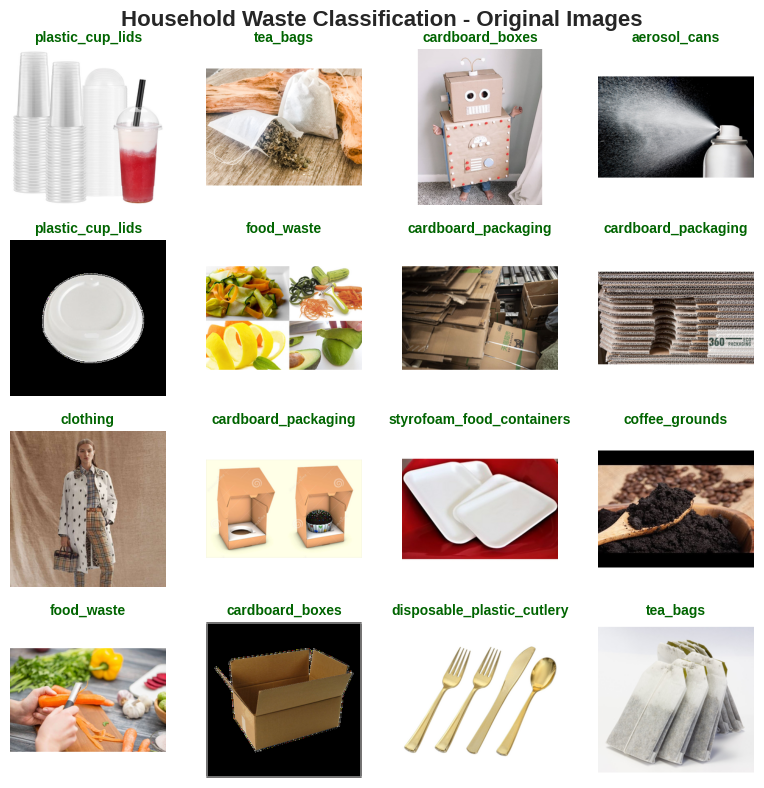

In [32]:
# Display original images from the full dataset (no transformations)
import random
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8")

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Household Waste Classification - Original Images', fontsize=16, fontweight='bold')

# Get 16 random samples
sample_indices = random.sample(range(len(full_dataset)), 16)

for i, idx in enumerate(sample_indices):
    row = i // 4
    col = i % 4

    original_img, label = full_dataset[idx]
    img_array = np.array(original_img)

    axes[row, col].imshow(img_array)
    axes[row, col].set_title(f"{get_class(label)}",
                            fontsize=10, fontweight='semibold',
                            color='darkgreen')
    axes[row, col].axis("off")

    for spine in axes[row, col].spines.values():
        spine.set_edgecolor(sns.color_palette("Set2", 8)[label % 8])
        spine.set_linewidth(2)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()
plt.style.use('default')
sns.reset_defaults()

## [IMAGE] Data Visualization
Display sample images from the dataset to understand the variety of waste items we're classifying.

In [33]:
import torch.optim as optim
from tqdm import tqdm

## [ROBOT] Model Architecture
Define the Vision Transformer models including both single-head and hierarchical dual-head architectures.

In [34]:
import torch
import timm
from torch import nn
import torch.nn.functional as F

# Option 1: Standard ViT-Base 
def make_vit_base(num_classes=30):
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)
    return model

# Option 2: More robust - Hybrid ViT approach (recommended)
class HybridViT(nn.Module):
    def __init__(self, num_classes=30, dropout=0.3):
        super().__init__()
        self.vit = timm.create_model('vit_small_patch16_224', pretrained=True)
        self.vit.head = nn.Identity()  # Remove original head
        
        # Add robust classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(384, 256),  # ViT-Small has 384 features
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        features = self.vit(x)
        return self.classifier(features)

# Focal Loss for handling class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, label_smoothing=0.1):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, label_smoothing=self.label_smoothing, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# Create the model
waste_classifier = HybridViT(num_classes=30, dropout=0.3)

# Test the model
waste_classifier.eval()
test_input = torch.randn(1, 3, 224, 224)
out = waste_classifier(test_input)
print(f"Output shape: {out.shape}")
print(f"Model parameters: {sum(p.numel() for p in waste_classifier.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in waste_classifier.parameters() if p.requires_grad):,}")

Output shape: torch.Size([1, 30])
Model parameters: 21,771,934
Trainable parameters: 21,771,934


In [35]:
# [CONSTRUCTION] Hierarchical Vision Transformer Model (Updated for 7 Super Classes)
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm import create_model

class HierarchicalViT(nn.Module):
    """
    Hierarchical Vision Transformer for waste classification
    
    Architecture:
    - Shared ViT backbone (pretrained vit_small_patch16_224)
    - Dual prediction heads:
      • Fine-grained: 30 waste classes
      • Super-class: 7 categories (Metal, Paper, Glass, Plastic, Styrofoam, Organic, Textiles)
    
    Training Strategy:
    - Phase 1: Freeze backbone, train heads only
    - Phase 2: Fine-tune last transformer blocks + heads
    """
    
    def __init__(self, 
                 num_fine_classes=30, 
                 num_super_classes=7,  # Updated from 6 to 7
                 model_name='vit_small_patch16_224',
                 pretrained=True,
                 dropout=0.1):
        super().__init__()
        
        self.num_fine_classes = num_fine_classes
        self.num_super_classes = num_super_classes
        
        # Load pretrained ViT backbone
        self.backbone = create_model(
            model_name, 
            pretrained=pretrained,
            num_classes=0  # Remove classification head
        )
        
        # Get feature dimension
        feature_dim = self.backbone.num_features  # 384 for vit_small
        
        # Shared feature processing
        self.feature_processor = nn.Sequential(
            nn.LayerNorm(feature_dim),
            nn.Dropout(dropout),
        )
        
        # Fine-grained classification head (30 classes)
        self.fine_classifier = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(feature_dim // 2, num_fine_classes)
        )
        
        # Super-class classification head (7 classes) - Updated
        self.super_classifier = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 4),
            nn.GELU(), 
            nn.Dropout(dropout),
            nn.Linear(feature_dim // 4, num_super_classes)  # Changed from 6 to 7
        )
        
        # Initialize heads with Xavier initialization
        self._initialize_heads()
    
    def _initialize_heads(self):
        """Initialize classification heads"""
        for module in [self.fine_classifier, self.super_classifier]:
            for layer in module:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    nn.init.constant_(layer.bias, 0)
    
    def forward(self, x):
        """
        Forward pass with dual outputs
        
        Args:
            x: Input images [batch_size, 3, 224, 224]
            
        Returns:
            fine_logits: Fine-grained predictions [batch_size, 30]
            super_logits: Super-class predictions [batch_size, 7]  # Updated comment
        """
        # Extract features from ViT backbone
        features = self.backbone(x)  # [batch_size, feature_dim]
        
        # Process shared features
        processed_features = self.feature_processor(features)
        
        # Dual predictions
        fine_logits = self.fine_classifier(processed_features)     # [batch_size, 30]
        super_logits = self.super_classifier(processed_features)   # [batch_size, 7] - Updated
        
        return fine_logits, super_logits
    
    def freeze_backbone(self):
        """Freeze backbone parameters for Phase 1 training"""
        for param in self.backbone.parameters():
            param.requires_grad = False
        print("🧊 Backbone frozen - Phase 1 training (heads only)")
    
    def unfreeze_last_blocks(self, num_blocks=2):
        """Unfreeze last transformer blocks for Phase 2 training"""
        # First freeze everything
        self.freeze_backbone()
        
        # Then unfreeze last few blocks
        if hasattr(self.backbone, 'blocks'):
            for block in self.backbone.blocks[-num_blocks:]:
                for param in block.parameters():
                    param.requires_grad = True
        
        # Always unfreeze norm and head if they exist
        if hasattr(self.backbone, 'norm'):
            for param in self.backbone.norm.parameters():
                param.requires_grad = True
                
        print(f"🔓 Last {num_blocks} transformer blocks unfrozen - Phase 2 training")
    
    def unfreeze_all(self):
        """Unfreeze all parameters"""
        for param in self.parameters():
            param.requires_grad = True
        print("🔓 All parameters unfrozen - Full fine-tuning")
    
    def get_trainable_params(self):
        """Get count of trainable parameters"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return trainable_params, total_params

# Test the updated model
print("🧪 TESTING HIERARCHICAL VIT MODEL (7 Super Classes)")
print("="*60)

# Create model instance
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
waste_classifier = HierarchicalViT(
    num_fine_classes=30,
    num_super_classes=7,
    dropout=0.3
).to(device)

print(f"📱 Model created on device: {device}")
print(f"[CONSTRUCTION]  Architecture: {waste_classifier.__class__.__name__}")
print(f"[TARGET] Fine-grained classes: {waste_classifier.num_fine_classes}")
print(f"🗂️  Super classes: {waste_classifier.num_super_classes}")

# Test forward pass
batch_size = 4
test_input = torch.randn(batch_size, 3, 224, 224).to(device)

with torch.no_grad():
    fine_out, super_out = waste_classifier(test_input)

print(f"\n🧪 FORWARD PASS TEST:")
print(f"   Input shape: {test_input.shape}")
print(f"   Fine logits: {fine_out.shape}")  # Should be [4, 30]
print(f"   Super logits: {super_out.shape}") # Should be [4, 7] - Updated

# Check parameter counts
trainable, total = waste_classifier.get_trainable_params()
print(f"\n[CHART] MODEL PARAMETERS:")
print(f"   Total parameters: {total:,}")
print(f"   Trainable parameters: {trainable:,}")
print(f"   Trainable percentage: {100*trainable/total:.1f}%")

# Test freezing/unfreezing
print(f"\n❄️  TESTING PARAMETER FREEZING:")
waste_classifier.freeze_backbone()
trainable_frozen, _ = waste_classifier.get_trainable_params()
print(f"   After backbone freeze: {trainable_frozen:,} trainable")

waste_classifier.unfreeze_last_blocks(num_blocks=2)
trainable_partial, _ = waste_classifier.get_trainable_params()
print(f"   After partial unfreeze: {trainable_partial:,} trainable")

# Verify outputs are valid
print(f"\n[CHECK] MODEL VALIDATION:")
print(f"   ✓ Fine-grained output shape correct: {fine_out.shape == (batch_size, 30)}")
print(f"   ✓ Super-class output shape correct: {super_out.shape == (batch_size, 7)}")  # Updated
print(f"   ✓ No NaN values in outputs: {not torch.isnan(fine_out).any() and not torch.isnan(super_out).any()}")
print(f"   ✓ Model parameters loaded: {total > 0}")

print(f"\n🎉 HierarchicalViT model successfully updated for 7 super classes!")

🧪 TESTING HIERARCHICAL VIT MODEL (7 Super Classes)
📱 Model created on device: cuda
[CONSTRUCTION]  Architecture: HierarchicalViT
[TARGET] Fine-grained classes: 30
🗂️  Super classes: 7

🧪 FORWARD PASS TEST:
   Input shape: torch.Size([4, 3, 224, 224])
   Fine logits: torch.Size([4, 30])
   Super logits: torch.Size([4, 7])

[CHART] MODEL PARAMETERS:
   Total parameters: 21,783,781
   Trainable parameters: 21,783,781
   Trainable percentage: 100.0%

❄️  TESTING PARAMETER FREEZING:
🧊 Backbone frozen - Phase 1 training (heads only)
   After backbone freeze: 118,117 trainable
🧊 Backbone frozen - Phase 1 training (heads only)
🔓 Last 2 transformer blocks unfrozen - Phase 2 training
   After partial unfreeze: 3,667,813 trainable

[CHECK] MODEL VALIDATION:
   ✓ Fine-grained output shape correct: True
   ✓ Super-class output shape correct: True
   ✓ No NaN values in outputs: True
   ✓ Model parameters loaded: True

🎉 HierarchicalViT model successfully updated for 7 super classes!


## [BRAIN] Hierarchical Vision Transformer
The main model with dual classification heads:
- **Fine-grained head**: Predicts specific waste types (30 classes)
- **Super-class head**: Predicts general categories (7 classes)

This allows the model to learn both detailed and general representations.

In [36]:
# [TARGET] Loss Functions for Hierarchical Classification (Updated for 7 Super Classes)

class FocalLoss(nn.Module):
    """
    Focal Loss for handling class imbalance
    """
    def __init__(self, alpha=1, gamma=2, num_classes=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

class HierarchicalLoss(nn.Module):
    """
    Hierarchical loss combining fine-grained and super-class predictions
    Updated for 7 super classes
    """
    def __init__(self, 
                 fine_weight=0.7, 
                 super_weight=0.3,
                 num_super_classes=7,  # Updated from 6 to 7
                 focal_gamma=2.0):
        super().__init__()
        self.fine_weight = fine_weight
        self.super_weight = super_weight
        self.num_super_classes = num_super_classes
        
        # Use focal loss for both fine and super classification
        self.fine_loss = FocalLoss(gamma=focal_gamma, num_classes=30)
        self.super_loss = FocalLoss(gamma=focal_gamma, num_classes=num_super_classes)
        
    def forward(self, fine_logits, super_logits, fine_targets, super_targets):
        """
        Compute hierarchical loss
        
        Args:
            fine_logits: [batch_size, 30] fine-grained predictions
            super_logits: [batch_size, 7] super-class predictions  # Updated comment
            fine_targets: [batch_size] fine-grained ground truth
            super_targets: [batch_size] super-class ground truth
        """
        # Ensure targets are long tensors
        fine_targets = fine_targets.long()
        super_targets = super_targets.long()
        
        # Compute individual losses
        loss_fine = self.fine_loss(fine_logits, fine_targets)
        loss_super = self.super_loss(super_logits, super_targets)
        
        # Weighted combination
        total_loss = self.fine_weight * loss_fine + self.super_weight * loss_super
        
        return total_loss, loss_fine, loss_super

# Create loss functions
print("[TARGET] LOSS FUNCTIONS SETUP (7 Super Classes)")
print("="*50)

# Focal loss for fine-grained classification
criterion = FocalLoss(alpha=1, gamma=2, num_classes=30)
print("✓ Focal Loss created for fine-grained classification (30 classes)")

# Hierarchical loss combining both levels
criterion_hierarchical = HierarchicalLoss(
    fine_weight=0.7,     # 70% weight on fine-grained accuracy
    super_weight=0.3,    # 30% weight on super-class accuracy
    num_super_classes=7, # Updated from 6 to 7
    focal_gamma=2.0      # Focal loss gamma parameter
)
print("✓ Hierarchical Loss created:")
print(f"   • Fine-grained weight: {criterion_hierarchical.fine_weight}")
print(f"   • Super-class weight: {criterion_hierarchical.super_weight}")
print(f"   • Number of super classes: {criterion_hierarchical.num_super_classes}")
print(f"   • Focal gamma: 2.0")

# Test the loss functions
print("\n🧪 TESTING LOSS FUNCTIONS:")
batch_size = 8
device = torch.device('cpu')  # Use CPU for testing

# Create dummy predictions and targets
fine_logits = torch.randn(batch_size, 30, device=device)
super_logits = torch.randn(batch_size, 7, device=device)  # Updated to 7 classes
fine_targets = torch.randint(0, 30, (batch_size,), device=device)
super_targets = torch.randint(0, 7, (batch_size,), device=device)  # Updated to 7 classes

# Test hierarchical loss
total_loss, loss_fine, loss_super = criterion_hierarchical(
    fine_logits, super_logits, fine_targets, super_targets
)

print(f"   Batch size: {batch_size}")
print(f"   Fine logits shape: {fine_logits.shape}")
print(f"   Super logits shape: {super_logits.shape}")
print(f"   Fine targets range: {fine_targets.min()}-{fine_targets.max()}")
print(f"   Super targets range: {super_targets.min()}-{super_targets.max()}")
print(f"   Fine loss: {loss_fine:.4f}")
print(f"   Super loss: {loss_super:.4f}")
print(f"   Total hierarchical loss: {total_loss:.4f}")

# Test individual focal loss
focal_loss = criterion(fine_logits, fine_targets)
print(f"   Individual focal loss: {focal_loss:.4f}")

print("\n[CHECK] All loss functions working correctly with 7 super classes!")
print(f"[CHART] Loss breakdown: {criterion_hierarchical.fine_weight*100:.0f}% fine + {criterion_hierarchical.super_weight*100:.0f}% super")

[TARGET] LOSS FUNCTIONS SETUP (7 Super Classes)
✓ Focal Loss created for fine-grained classification (30 classes)
✓ Hierarchical Loss created:
   • Fine-grained weight: 0.7
   • Super-class weight: 0.3
   • Number of super classes: 7
   • Focal gamma: 2.0

🧪 TESTING LOSS FUNCTIONS:
   Batch size: 8
   Fine logits shape: torch.Size([8, 30])
   Super logits shape: torch.Size([8, 7])
   Fine targets range: 4-27
   Super targets range: 1-5
   Fine loss: 4.5803
   Super loss: 1.6464
   Total hierarchical loss: 3.7001
   Individual focal loss: 4.5803

[CHECK] All loss functions working correctly with 7 super classes!
[CHART] Loss breakdown: 70% fine + 30% super


## [TARGET] Loss Functions
Define specialized loss functions for hierarchical training:
- **Focal Loss**: Handles class imbalance by focusing on hard examples
- **Hierarchical Loss**: Combines fine-grained and super-class losses with configurable weights

In [ ]:
# [WRENCH] Quick Setup Check
print("[WRENCH] Setup Verification...")

# Check key components
checks = [
    ('Dataset', 'full_dataset' in globals()),
    ('Class mappings', 'CLASS_IDX_TO_SUPER_IDX' in globals()),
    ('Model', 'waste_classifier' in globals()),
    ('Loss function', 'criterion_hierarchical' in globals()),
    ('Transforms', 'train_dataset_transformed' in globals())
]

all_good = True
for name, condition in checks:
    status = "[CHECK]" if condition else "[X]"
    print(f"   {status} {name}")
    if not condition:
        all_good = False

if all_good:
    print("[CHECK] Ready for training!")
    
    # Quick model test
    device = torch.device('mps' if torch.backends.mps.is_available() else 
                         ('cuda' if torch.cuda.is_available() else 'cpu'))
    print(f"Device: {device}")
    
    # Test forward pass
    test_input = torch.randn(2, 3, 224, 224).to(device)
    waste_classifier.eval()
    with torch.no_grad():
        fine_out, super_out = waste_classifier(test_input)
    print(f"Model test: Fine {fine_out.shape}, Super {super_out.shape}")
else:
    print("[X] Setup incomplete! Run previous cells first.")

## [WRENCH] Training Setup & Validation
Verify that all components are properly initialized and ready for training. This includes model, loss functions, data loaders, and device setup.

In [ ]:
# [ROCKET] Hierarchical Training Functions (Complete)
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm
import numpy as np
import time

def train_epoch_hierarchical(model, train_loader, criterion_hierarchical, optimizer, device):
    """Streamlined training function with tqdm progress"""
    model.train()
    total_loss = 0
    fine_correct = 0
    super_correct = 0
    total_samples = 0
    
    pbar = tqdm(train_loader, desc="Training", leave=False)
    
    for images, fine_labels in pbar:
        # Move to device
        images = images.to(device)
        fine_labels = fine_labels.to(device)
        
        # Convert to super labels
        super_labels = torch.tensor([
            CLASS_IDX_TO_SUPER_IDX.get(int(label), 0) for label in fine_labels.cpu()
        ]).to(device)
        
        # Forward pass
        fine_logits, super_logits = model(images)
        loss, fine_loss, super_loss = criterion_hierarchical(
            fine_logits, super_logits, fine_labels, super_labels
        )
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Calculate accuracy
        _, fine_pred = torch.max(fine_logits, 1)
        _, super_pred = torch.max(super_logits, 1)
        
        fine_correct += (fine_pred == fine_labels).sum().item()
        super_correct += (super_pred == super_labels).sum().item()
        total_samples += images.size(0)
        total_loss += loss.item()
        
        # Update progress bar
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Fine': f'{100*fine_correct/total_samples:.1f}%',
            'Super': f'{100*super_correct/total_samples:.1f}%'
        })
    
    return total_loss/len(train_loader), 100*fine_correct/total_samples, 100*super_correct/total_samples

def eval_epoch_hierarchical(model, test_loader, criterion_hierarchical, device):
    """Streamlined evaluation function with tqdm progress"""
    model.eval()
    total_loss = 0
    fine_correct = 0
    super_correct = 0
    total_samples = 0
    
    pbar = tqdm(test_loader, desc="Validation", leave=False)
    
    with torch.no_grad():
        for images, fine_labels in pbar:
            # Move to device
            images = images.to(device)
            fine_labels = fine_labels.to(device)
            
            # Convert to super labels
            super_labels = torch.tensor([
                CLASS_IDX_TO_SUPER_IDX.get(int(label), 0) for label in fine_labels.cpu()
            ]).to(device)
            
            # Forward pass
            fine_logits, super_logits = model(images)
            loss, _, _ = criterion_hierarchical(
                fine_logits, super_logits, fine_labels, super_labels
            )
            
            # Calculate accuracy
            _, fine_pred = torch.max(fine_logits, 1)
            _, super_pred = torch.max(super_logits, 1)
            
            fine_correct += (fine_pred == fine_labels).sum().item()
            super_correct += (super_pred == super_labels).sum().item()
            total_samples += images.size(0)
            total_loss += loss.item()
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Fine': f'{100*fine_correct/total_samples:.1f}%',
                'Super': f'{100*super_correct/total_samples:.1f}%'
            })
    
    return total_loss/len(test_loader), 100*fine_correct/total_samples, 100*super_correct/total_samples

print("[CHECK] Training functions ready")

## [ROCKET] Training Functions
Define streamlined training and validation functions with tqdm progress bars for real-time monitoring of loss and accuracy.

In [ ]:
# Hierarchical Training Execution
print("Starting Hierarchical Training")
print("="*50)

# Setup
device = torch.device('mps' if torch.backends.mps.is_available() else 
                     ('cuda' if torch.cuda.is_available() else 'cpu'))
print(f"Device: {device}")

waste_classifier = waste_classifier.to(device)

# Training parameters
EPOCHS = 15
INITIAL_LR = 1e-3
MIN_LR = 1e-5

# Ensure data loaders exist (use existing ones or create new ones)
print("Checking data loaders...")
try:
    # Test if existing loaders work
    test_batch = next(iter(train_loader))
    print(f"Using existing data loaders: {len(train_loader)} train, {len(test_loader)} test batches")
except (NameError, StopIteration):
    print("Creating new data loaders...")
    train_loader = DataLoader(train_dataset_transformed, batch_size=64, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_dataset_transformed, batch_size=64, shuffle=False, num_workers=0)
    print(f"Created data loaders: {len(train_loader)} train, {len(test_loader)} test batches")

# Optimizer and scheduler
optimizer = torch.optim.AdamW(waste_classifier.parameters(), lr=INITIAL_LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=MIN_LR)

# Training history
train_losses, val_losses = [], []
train_fine_accs, val_fine_accs = [], []
train_super_accs, val_super_accs = [], []
best_val_acc = 0

print(f"\nStarting training for {EPOCHS} epochs...")
print(f"Dataset: {len(train_loader)} train batches, {len(test_loader)} val batches")
print(f"Model: {waste_classifier.__class__.__name__} on {device}")
print("-" * 80)
print("Epoch | LR      | Train Loss | Train Fine% | Train Super% | Val Loss | Val Fine% | Val Super%")
print("-" * 80)

# Main training loop
for epoch in range(1, EPOCHS + 1):
    # Training phase
    train_loss, train_fine_acc, train_super_acc = train_epoch_hierarchical(
        waste_classifier, train_loader, criterion_hierarchical, optimizer, device
    )
    
    # Validation phase
    val_loss, val_fine_acc, val_super_acc = eval_epoch_hierarchical(
        waste_classifier, test_loader, criterion_hierarchical, device
    )
    
    # Update scheduler
    scheduler.step()
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_fine_accs.append(train_fine_acc)
    val_fine_accs.append(val_fine_acc)
    train_super_accs.append(train_super_acc)
    val_super_accs.append(val_super_acc)
    
    # Print epoch results in tabular format
    lr = optimizer.param_groups[0]['lr']
    print(f"{epoch:5d} | {lr:.6f} | {train_loss:10.4f} | {train_fine_acc:11.1f} | {train_super_acc:12.1f} | {val_loss:8.4f} | {val_fine_acc:9.1f} | {val_super_acc:10.1f}")
    
    # Save best model and show improvement
    current_acc = val_fine_acc + val_super_acc
    if current_acc > best_val_acc:
        best_val_acc = current_acc
        torch.save(waste_classifier.state_dict(), 'best_hierarchical_model.pth')
        print(f"      *** New best model saved! Combined accuracy: {current_acc/2:.1f}%")

print("-" * 80)
print(f"\nTraining completed successfully!")
print(f"Best combined accuracy: {best_val_acc/2:.1f}%")
print(f"Final results:")
print(f"   Fine-grained:  Train {train_fine_accs[-1]:.1f}% | Val {val_fine_accs[-1]:.1f}%")
print(f"   Super-class:   Train {train_super_accs[-1]:.1f}% | Val {val_super_accs[-1]:.1f}%")
print(f"   Overall Loss:  Train {train_losses[-1]:.4f} | Val {val_losses[-1]:.4f}")

## [RUNNER] Training Execution
Execute the main training loop for 15 epochs with:
- **AdamW optimizer** with cosine annealing learning rate schedule
- **Live progress tracking** with tqdm bars
- **Automatic best model saving** based on combined accuracy
- **Real-time metrics** for both fine-grained and super-class predictions

In [ ]:
#  Training Results Visualization
import matplotlib.pyplot as plt

if 'train_losses' in globals() and len(train_losses) > 0:
    epochs = range(1, len(train_losses) + 1)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('[TARGET] Hierarchical Training Results', fontsize=16, fontweight='bold')
    
    # Loss curves
    ax1.plot(epochs, train_losses, 'b-', label='Training', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Validation', linewidth=2)
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Fine-grained accuracy
    ax2.plot(epochs, train_fine_accs, 'g-', label='Training', linewidth=2)
    ax2.plot(epochs, val_fine_accs, 'orange', label='Validation', linewidth=2)
    ax2.set_title('Fine-grained Accuracy (30 classes)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 100)
    
    # Super-class accuracy
    ax3.plot(epochs, train_super_accs, 'purple', label='Training', linewidth=2)
    ax3.plot(epochs, val_super_accs, 'brown', label='Validation', linewidth=2)
    ax3.set_title('Super-class Accuracy (7 categories)')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 100)
    
    # Final comparison
    categories = ['Fine-grained', 'Super-class']
    final_train = [train_fine_accs[-1], train_super_accs[-1]]
    final_val = [val_fine_accs[-1], val_super_accs[-1]]
    
    x = np.arange(len(categories))
    width = 0.35
    
    ax4.bar(x - width/2, final_train, width, label='Training', alpha=0.8)
    ax4.bar(x + width/2, final_val, width, label='Validation', alpha=0.8)
    ax4.set_title('Final Accuracy Comparison')
    ax4.set_ylabel('Accuracy (%)')
    ax4.set_xticks(x)
    ax4.set_xticklabels(categories)
    ax4.legend()
    ax4.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n Training Summary:")
    print(f"Best Fine-grained: {max(val_fine_accs):.1f}%")
    print(f"Best Super-class: {max(val_super_accs):.1f}%")
    print(f"Final Fine-grained: {val_fine_accs[-1]:.1f}%")
    print(f"Final Super-class: {val_super_accs[-1]:.1f}%")
else:
    print("[X] No training data found. Run training first.")

## [CHART] Results & Visualization
Visualize training progress with comprehensive plots showing:
- **Loss curves** for training and validation
- **Accuracy trends** for both classification heads
- **Final performance comparison** between training and validation
- **Training summary statistics**

In [ ]:
# Final Summary
print("Hierarchical Waste Classifier Training Complete!")
print("="*50)

if 'val_fine_accs' in globals() and len(val_fine_accs) > 0:
    print(f"Results:")
    print(f"   Best Fine-grained Accuracy: {max(val_fine_accs):.1f}%")
    print(f"   Best Super-class Accuracy: {max(val_super_accs):.1f}%")
    print(f"   Final Fine-grained Accuracy: {val_fine_accs[-1]:.1f}%")
    print(f"   Final Super-class Accuracy: {val_super_accs[-1]:.1f}%")
    
    # Test prediction
    print(f"\nQuick test prediction:")
    waste_classifier.eval()
    with torch.no_grad():
        sample_batch = next(iter(test_loader))
        images, labels = sample_batch
        images = images[:1].to(device)  # Take first image
        fine_out, super_out = waste_classifier(images)
        
        fine_pred = torch.argmax(fine_out, dim=1).item()
        super_pred = torch.argmax(super_out, dim=1).item()
        
        fine_class = class_names[fine_pred]
        super_class = SUPER_CLASS_NAMES[super_pred]
        
        print(f"   Predicted: {fine_class} -> {super_class}")
        
    print(f"\nModel saved as: best_hierarchical_model.pth")
else:
    print("No training completed yet.")

print("\nNotebook execution complete!")

In [ ]:
# [BROOM] Clean Up for GitHub/Kaggle Compatibility
import sys
import locale

# Check current encoding
print("System encoding:", sys.stdout.encoding)
print("Locale encoding:", locale.getpreferredencoding())

# Clean up any variables that might contain problematic characters
import gc
gc.collect()

print("[CHECK] Cleanup completed - ready for commit to GitHub")

## 🎉 Final Summary & Test
Display final training results, run a quick test prediction to verify the model works correctly, and confirm the trained model has been saved.